# Tutorial: Using Vision Foundation Models for Semi-Supervised Promptable Instance Segmentation

In this tutorial, we introduce you to applications of vision foundation models for image segmentation in microscopy. In particular, you will learn about [μSAM](https://doi.org/10.1038/s41592-024-02580-4), a vision foundation model for interactive (and automatic) instance segmentation specialized for microscopy images.

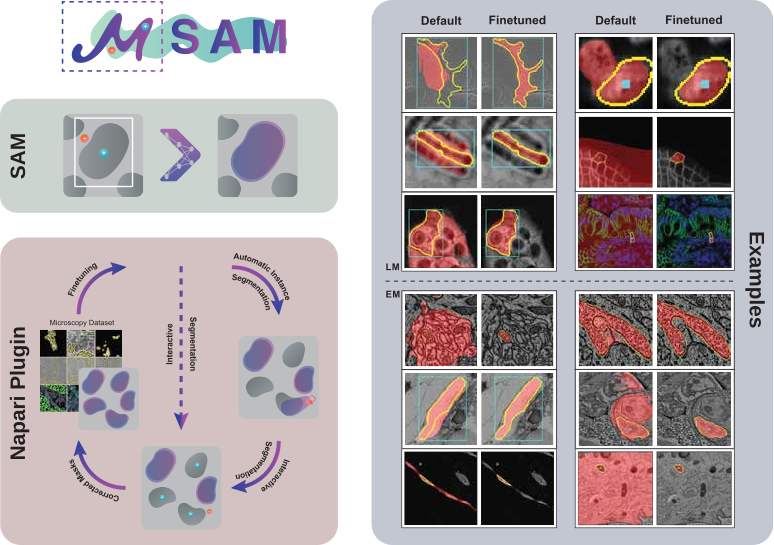


μSAM is based on [Segment Anything Model](https://segment-anything.com/) (SAM) by Meta, which introduced a novel architecture for performing interactive segmentation on a diverse range of tasks in natural images.
The key strengths of SAM lies behind 1) the training scheme and 2) the large amount of training data (composed of >11 million images with ca. 1 __billion__ masks!). It captures precise object-level representations by simulating _interactive_ segmentation during training (using boxes and positive or negative points), enabling a generalizable capability to "segment anything". Their [paper](https://openaccess.thecvf.com/content/ICCV2023/papers/Kirillov_Segment_Anything_ICCV_2023_paper.pdf) demonstrates impressive zero-shot capabilities for interactive segmentation. SAM extends their method to perform automatic segmentation, by placing a grid of points over an image to obtain the most relevant object mask segmented for each point.

μSAM demonstrates the limitations of SAM for interactive and automatic segmentation in microscopy. Motivated by it's promising capabilities, the authors finetuned SAM on a large microscopy dataset to address the severe domain shift between natural images and microscopy images, creating a generalist model each for light microscopy and electron microscopy domain. In addition, the team introduces a novel automatic instance segmentation pipeline by jointly training SAM with an additional segmentation decoder, to observe faster and superior segmentation quality supported and enhanced interactive segmentation.

However, (μ)SAM has a high computational requirement for training, as the image encoder (i.e. a [vision transformer](https://arxiv.org/abs/2010.11929) (ViT)) is the part of backbone which benefits the most with further training on downstream tasks. It arises several questions, for [parameter-efficient finetuning](https://doi.org/10.48550/arXiv.2502.00418) on user-level hardware, or opting for advanced prompting strategies in a semi-supervised fashion, to utilize the strengths of interactive segmentation without any manual intervention. We explore the second question in this tutorial to understand and evaluation scenarios where vision foundation models like (μ)SAM can be automatically prompted with user-level input prompts to assess the quality of interactive segmentation without user-provided input prompts.

To achieve this, we introduce you to [Spotiflow](https://doi.org/10.1101/2024.02.01.578426), a spot detection method (powered by deep neural networks) for microscopy, which you will task to generate _point prompts_ for μSAM.

For the first task, we will use a domain-specific Spotiflow model to detect the individual microbial species in their colonies. Next, we utilize the detected spots to simulate user-provided point prompts as inputs to μSAM and compare promptable segmentation with automatic segmentation offered by μSAM. Discuss your observations with the TAs!

_Happy coding!_

## Running this notebook

### For `BARD` users:
You should have access to `conda` package manager on `BARD`. You should select the `sam (Python 3.11.11)` kernel to run the notebook. And then, you are good to code.

### For other users:
You can also run this notebook in the cloud on [Kaggle Notebooks](https://www.kaggle.com/code/). This service offers free usage of a GPU to speed up running the code. You need to install [`micro-sam`](https://github.com/computational-cell-analytics/micro-sam) and [`spotiflow`](https://github.com/weigertlab/spotiflow) yourself. Look into the documentation yourself for details.

## Importing the libraries

In [ ]:
import os
from glob import glob
from tqdm.auto import tqdm
from typing import Optional, Literal, Tuple, List, Union

import matplotlib.pyplot as plt
import numpy as np
import imageio.v3 as imageio
from skimage.measure import regionprops
from skimage.measure import label as connected_components
from skimage.color import label2rgb

from torch_em.data.datasets.light_microscopy.ifnuclei import get_ifnuclei_paths

from spotiflow.model import Spotiflow

from segment_anything import SamPredictor

from micro_sam.prompt_based_segmentation import segment_from_points
from micro_sam.util import get_sam_model, precompute_image_embeddings
from micro_sam.automatic_segmentation import get_predictor_and_segmenter, automatic_instance_segmentation

In [ ]:
# Let's set the path to the folder where all required files are stored.
ROOT = "/scratch/denbi/k8s/ADL4IA_flexprojects/flexproject1"

### Bacteria Colony (Instance) Segmentation

Our first task is to detect and segment microbial colonies in agar plates. For this task, we will use the [AGAR](https://agar.neurosys.com/) dataset.

> TIP 1: Let's start by visualizing a few images in the dataset (always a good strategy to first understand the images and associated task!)

In [ ]:
# Let's get the filepaths to the input images from AGAR data.

def get_agar_paths(
    path: Union[os.PathLike, str], resolution: Optional[Literal["higher", "lower"]] = None
) -> Tuple[List[str], List[str]]:
    """Get the filepaths to the input image and corresponding metadata file.

    Args:
        path: The folder where the input data is stored.
        resolution: The choice of resolution.

    Returns:
        List of filepaths for the input data.
        List of filepaths for the corresponding metadata.
    """

    # Directory where the AGAR data is stored.
    data_dir = os.path.join(path, "AGAR_representative")

    # Get path to one low-res image and corresponding metadata file.
    resolution = ("*" if resolution is None else resolution) + "-resolution"
    image_paths = sorted(glob(os.path.join(data_dir, resolution, "*.jpg")))
    metadata_paths = [p.replace(".jpg", ".json") for p in image_paths]
    metadata_paths = [p for p in metadata_paths if os.path.exists(p)]

    assert image_paths and len(image_paths) == len(metadata_paths)

    return image_paths, metadata_paths

In [ ]:
# Next, we obtain the filepaths to the input images (low-resolution images from AGAR)
image_paths, _ = get_agar_paths(path=os.path.join(ROOT, "data", "agar"), resolution="lower")

# Load the first few images
images_subset = tuple(imageio.imread(p) for p in image_paths[:3])
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax, img in zip(axs, images_subset):
    ax.imshow(img)
    ax.axis("off")

<div class="alert alert-block alert-warning">
    <b>Task</b>: Explore the data: How many images are there in the dataset? How many channels do they have?
</div>

In [ ]:
# TODO: Your code here:

<div class="alert alert-block alert-info">
    <b>Question</b>: From the images shown above, name a few challenges according to you, to segment bacteria colonies in plates?
</div>

TODO: Your answer here:

...

### Task 1: Spot Detection

Next, we will load a Spotiflow model trained on this dataset to run the detection on the images. The output of Spotiflow are detected spots, each in `(Y, X)` coordinates, corresponding to the approximated center of each detected colony.

In [ ]:
# Get the folder to the Spotiflow model trained on AGAR data.
spotiflow_model_dir = os.path.join(ROOT, "models", "spotiflow")

# Load the AGAR model
model = Spotiflow.from_folder(
    pretrained_path=os.path.join(spotiflow_model_dir, "spotiflow_agar", "agar_model"),
)

# Detect colonies as coordinates
spots_per_image = []
for image_path in tqdm(image_paths, desc="Running Spotiflow on each image"):
    image = imageio.imread(image_path)  # Read the input image.
    detected_spots, _ = model.predict(image, verbose=False, min_distance=9)  # Run prediction with Spotiflow pretrained model.
    spots_per_image.append(detected_spots)


# Plot the input image and corresponding detected colonies.
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(images_subset[0])
ax.scatter(spots_per_image[0][:, 1], spots_per_image[0][:, 0], s=10, c="r", alpha=0.5, marker="x")
ax.axis("off")

### Task 2: Promptable Instance Segmentation

We now have the locations of individual colonies. Let's use their coordinate positions to simulate points as input prompts to `micro-sam`!

In [ ]:
def run_promptable_segmentation(
    predictor: SamPredictor, image: np.ndarray, point_prompts: List[List[Tuple[int, int]]],
) -> np.ndarray:
    """Functionality to run promptable semgentation using generated point prompts.

    Args:
        predictor: The Segment Anything model to generate predictions with input prompts.
        image: The input image.
        point_prompts: The positive point prompts to generate masks.

    Returns:
        The instance segmentation.
    """

    # Compute the image embeddings.
    image_embeddings = precompute_image_embeddings(
        predictor=predictor,
        input_=image,
        ndim=2,  # With RGB images, we should have channels last and must set ndim to 2.
        verbose=False,
        # tile_shape=(384, 384),  # The tile shape for larger images to perform prediction using tiling-window.
        # halo=(64, 64),  # The overlap shape for larger images to perform prediction using tiling-window.
        # save_path=f"embeddings_{i}.zarr",  # Stores the image embeddings locally, otherwise computes on-the-fly.
    )

    # Run promptable segmentation.
    masks = [
        segment_from_points(
            predictor=predictor,
            points=np.array([each_point_prompt]),  # Each point coordinate (Y, X) is expected as array.
            labels=np.array([1]),  # Each corresponding label, eg. 1 corresponds positive, is expected as array.
            image_embeddings=image_embeddings,
        ).squeeze() for each_point_prompt in point_prompts
    ]

    # Merge all masks into one segmentation.
    # 1. First, we get the area per object and try to map as: big objects first and small ones then
    #    (to avoid losing tiny objects near-by or to any possible overlaps)
    mask_props = [{"mask": mask, "area": regionprops(connected_components(mask))[0].area} for mask in masks]

    # 2. Next, we assort based on area from greatest to smallest.
    assorted_masks = sorted(mask_props, key=(lambda x: x["area"]), reverse=True)
    masks = [per_mask["mask"] for per_mask in assorted_masks]

    # 3. Finally, we merge all individual segmentations into one.
    segmentation = np.zeros(image.shape[:2], dtype=int)
    for j, mask in enumerate(masks, start=1):
        segmentation[mask > 0] = j

    return segmentation

In [ ]:
# Get the Segment Anything Model to simulate interactive segmentation with detected spots.
predictor = get_sam_model(
    model_type="vit_b_lm",
    checkpoint_path=os.path.join(ROOT, "models", "micro-sam", "vit_b_lm_v3.pt")
)

# Run simulated interactive segmentation per image.
for i, (image_path, point_prompts) in tqdm(
    enumerate(zip(image_paths, spots_per_image)),
    desc="Running micro-sam on each image",
    total=len(image_paths),
):
    image = imageio.imread(image_path)  # Read the input image.

    # Run the promptable segmentation using `micro-sam`
    segmentation = run_promptable_segmentation(predictor=predictor, image=image, point_prompts=point_prompts)

    # Plot the first 3 images and the resulting segmentation masks
    if i < 3:
        fig, axes = plt.subplots(1, 2, figsize=(15, 10))
        axes[0].imshow(image)
        axes[0].axis("off")
        axes[0].set_title("Image")

        axes[1].imshow(label2rgb(segmentation, image, bg_label=0))
        axes[1].axis("off")
        axes[1].set_title("Segmentation (Spotiflow -> μSAM)")

### Task 3: Compare with Automatic Instance Segmentation (supported by μSAM)

Next, we compare our automatically prompted instance segmentation with end-to-end automatic instance segmentation quality of `micro-sam`, which generates individual instances by post-processing predicted foreground and distance maps to perform seeded watershed, i.e. does not use any input prompts.

In [ ]:
# Get the Segment Anything model and the corresponding segmentation class.
predictor, segmenter = get_predictor_and_segmenter(
    model_type="vit_b",
    checkpoint=os.path.join(ROOT, "models", "micro-sam", "vit_b_lm_v3.pt"),
    amg=False,  # i.e. runs our new automatic instance segmentation.
    is_tiled=False,  # overwrite if automatic segmentation is run based on tiling window
)

for i, (image_path, point_prompts) in tqdm(
    enumerate(zip(image_paths, spots_per_image)),
    desc="Running automatic segmentation with micro-sam",
    total=len(image_paths)
):
    image = imageio.imread(image_path)  # Load the input image

    # Get automatic segmentation
    segmentation = automatic_instance_segmentation(
        predictor=predictor,
        segmenter=segmenter,
        input_path=image,
        ndim=2,
        verbose=False,
    )

    # Plot the first 3 images and the resulting segmentation masks
    if i < 3:
        fig, axes = plt.subplots(1, 2, figsize=(15, 10))
        axes[0].imshow(image)
        axes[0].axis("off")
        axes[0].set_title("Image")

        axes[1].imshow(label2rgb(segmentation, image, bg_label=0))
        axes[1].axis("off")
        axes[1].set_title("Segmentation (μSAM)")

<div class="alert alert-block alert-info">
    <b>Question</b>: Can you comment on the two applied methods and your observation on the segmentation quality?
</div>

TODO: Your answer here:

...

### Nuclei (Instance) Segmentation

For this task, we will use a Spotiflow model trained on the [DSB18](https://doi.org/10.1038/s41592-019-0612-7) dataset, which consists of DAPI-stained nuclei.

Let's play with an out-of-domain dataset, [IFNuclei](https://doi.org/10.1038/s41597-020-00608-w), containing DAPI-stained images with nuclei annotations. We will follow the same steps as before: 1) Load the data, 2) Run Spotiflow, and 3) Run `micro-sam` with the detected nuclei for promptable segmentation.

Below provided are a few suggestions and hints for this task:

1. Load the `spotiflow` model:
```python
model = Spotiflow.from_folder(
    pretrained_path=os.path.join(spotiflow_model_dir, "spotiflow_dsb18", "dsb18_model"),
)
```

2. Experiment with Hyperparameters in `spotiflow`:
```python
detected_spots, _ = model.predict(
    image,
    verbose=False,
    min_distance=9,  # minimun distance between two peaks.
    prob_thresh=0.4  # probability threshold for peak detection
    # etc...
)
```

### OR

- You can choose your own task to combine `Spotiflow` x `μSAM` on your data.
- You can discuss other advanced applications with `Spotiflow` and/or `μSAM` for your data, as well as other suitable tools.

In [ ]:
# NOTE: Here is a supporting script to get the DAPI-stained images.
image_paths, gt_paths = get_ifnuclei_paths(path=os.path.join(ROOT, "data", "if_nuclei"))
image_paths = [p for p in image_paths if os.path.basename(p).startswith("normal")]
gt_paths = [p for p in gt_paths if os.path.basename(p).startswith("normal")]

In [ ]:
# TODO: Your code here:

## Thoughts:

<div class="alert alert-block alert-warning">
    <b>Question 1</b>: Do you think the promptable segmentation framework, based on bacteria colonies, would work for nuclei segmentation? Comment on your thoughts!
</div>

<div class="alert alert-block alert-warning">
    <b>Question 2</b>: Looking at the first results of the DSB18 model for spot detection on IFNuclei data, this is probably not what we would expected. Can you think of what could be happening?
</div>

<div class="alert alert-block alert-info">
    <b>Hint</b>: Despite the similarity between the training data and our out-of-domain data, several settings, e.g. the pixel size could be different, which can lead to the specialized model not generalizing well due to the different apparent object sizes. Despite more detections per object than actual nuclei, it should not cause problems with promtable segmentation using μSAM if the detection are inside a nucleus, as the masks would overlap with each other.
</div>

<div class="alert alert-block alert-warning">
    <b>Question 3</b>: What would happen if a positive point prompt is outside the object? Can you think of a way to prevent / post-process the result to avoid issues?
</div>

<div class="alert alert-block alert-warning">
    <b>Question 4</b>: What are the key takeaways from this project?
</div>

_This notebook was last ran on Feb 14th 2025_

Authors: Anwai Archit and Albert Dominguez Mantes